#Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

#Data Downloading and Feature-Target Separation

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Prepare the features and targets
train_features = train_dataset.data.unsqueeze(1).float() / 255.0
train_targets = train_dataset.targets
test_features = test_dataset.data.unsqueeze(1).float() / 255.0
test_targets = test_dataset.targets

# Normalize the data
train_features = (train_features - 0.5) / 0.5
test_features = (test_features - 0.5) / 0.5


#FGSM attack

Fast Gradient Sign Method (FGSM) attack perturbs input images based on the gradient of the loss concerning the input.It is a single-step attack with perturbation controlled by epsilon

In [ ]:
# Define the FGSM attack function
def fgsm_attack(model, images, labels, eps=0.3):
    model.eval()
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    # Forward pass
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Generate adversarial examples
    adv_images = images + eps * images.grad.sign()
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()
    return adv_images

#Deep CNN model

This is a bit different from PGD since FGSM is a single step attack, we are using 3 convolutional layers with ReLU activation and max-pooling for feature extraction.

In [ ]:
# Define a deeper CNN model
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Output: 28x28x64
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 28x28x128
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 14x14x128

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Output: 14x14x256
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 7x7x256

        self.fc1 = nn.Linear(7 * 7 * 256, 1024)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.relu3(self.conv3(x))
        x = self.pool2(x)
        x = x.view(-1, 7 * 7 * 256)  # Flatten
        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        return x


#Initialize model

In [ ]:
# Initialize the model, device, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


#New Dataset

In [ ]:
# Generate a new dataset with FGSM attack
def generate_fgsm_dataset(model, features, targets, eps=0.3):
    original_features = features.clone()
    targets = targets.clone()

    perturbed_features = []
    batch_size = 128
    model.eval()

    for i in range(0, len(features), batch_size):
        batch_features = features[i:i + batch_size].to(device)
        batch_targets = targets[i:i + batch_size].to(device)
        perturbed_batch = fgsm_attack(model, batch_features, batch_targets, eps)
        perturbed_features.append(perturbed_batch.cpu())

    perturbed_features = torch.cat(perturbed_features, dim=0)

    combined_features = torch.cat([original_features, perturbed_features], dim=0)
    combined_targets = torch.cat([targets, targets], dim=0)

    return TensorDataset(combined_features, combined_targets)


In [ ]:
# Generate perturbed training and testing datasets
new_train_dataset = generate_fgsm_dataset(model, train_features, train_targets, eps=0.3)
new_test_dataset = generate_fgsm_dataset(model, test_features, test_targets, eps=0.3)

# Create DataLoader for both new training and testing datasets
new_train_loader = DataLoader(new_train_dataset, batch_size=64, shuffle=True)
new_test_loader = DataLoader(new_test_dataset, batch_size=64, shuffle=False)


#Training new data set

In [ ]:

# Define the training function
def train_model(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {100. * correct / total:.2f}%")

# Train the model
train_model(model, new_train_loader, epochs=5)



Epoch 1: Loss = 176.1927, Accuracy = 97.06%
Epoch 2: Loss = 54.9552, Accuracy = 99.12%
Epoch 3: Loss = 36.6784, Accuracy = 99.44%
Epoch 4: Loss = 27.3101, Accuracy = 99.58%
Epoch 5: Loss = 23.0498, Accuracy = 99.69%


In [ ]:
def train_model_with_epsilon(model, train_loader, epsilon_values, epochs=5):
    model.train()
    for epsilon in epsilon_values:
        print(f"\nTraining with epsilon = {epsilon:.2f}")

        for epoch in range(epochs):
            epoch_loss = 0
            correct = 0
            total = 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                # Apply adversarial perturbation based on epsilon
                perturbed_data = data + epsilon * torch.randn_like(data).to(device)

                optimizer.zero_grad()
                outputs = model(perturbed_data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                _, predicted = outputs.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

            print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {100. * correct / total:.2f}%")


In [ ]:
epsilon_values = [0.1, 0.2, 0.3]
train_model_with_epsilon(model, new_train_loader, epsilon_values, epochs=5)



Training with epsilon = 0.10
Epoch 1: Loss = 22.6636, Accuracy = 99.68%
Epoch 2: Loss = 18.7704, Accuracy = 99.73%
Epoch 3: Loss = 18.1768, Accuracy = 99.77%
Epoch 4: Loss = 14.4515, Accuracy = 99.80%
Epoch 5: Loss = 12.4965, Accuracy = 99.83%

Training with epsilon = 0.20
Epoch 1: Loss = 27.5962, Accuracy = 99.63%
Epoch 2: Loss = 16.5941, Accuracy = 99.75%
Epoch 3: Loss = 19.0641, Accuracy = 99.74%
Epoch 4: Loss = 16.0915, Accuracy = 99.77%
Epoch 5: Loss = 18.5043, Accuracy = 99.76%

Training with epsilon = 0.30
Epoch 1: Loss = 38.4173, Accuracy = 99.42%
Epoch 2: Loss = 29.4935, Accuracy = 99.55%
Epoch 3: Loss = 28.9787, Accuracy = 99.56%
Epoch 4: Loss = 27.1358, Accuracy = 99.58%
Epoch 5: Loss = 24.9287, Accuracy = 99.64%


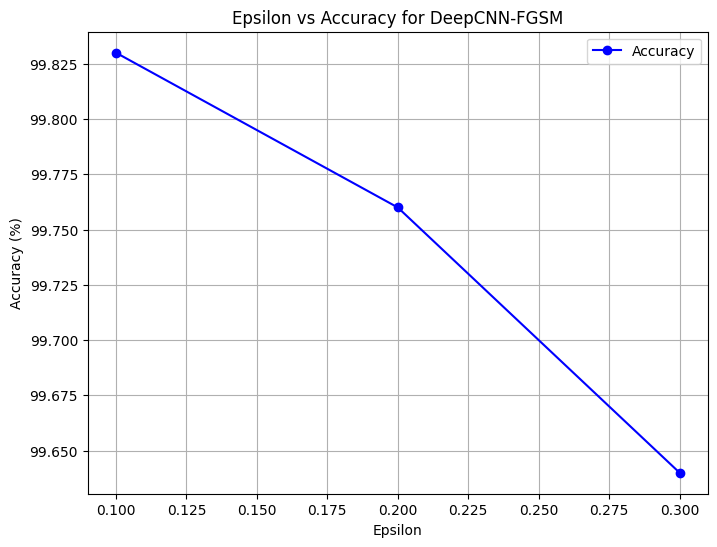

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data for each epsilon value
epsilon_values = [0.10, 0.20, 0.30]
accuracies = [99.83, 99.76, 99.64]  # The accuracy values you provided for each epsilon

# Plotting epsilon vs accuracy
plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')

# Labeling the axes
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Epsilon vs Accuracy for DeepCNN-FGSM')

# Adding gridlines and a legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


#Evaluation

In [ ]:
# Define the evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

    print(f"Test Accuracy: {100. * correct / total:.2f}%")

# Evaluate the model on the new test dataset
evaluate_model(model, new_test_loader)

Test Accuracy: 99.22%
